## l2hmc

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 120
%load_ext rich

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 120 seconds


In [2]:
import os
import sys
from pathlib import Path

modulepath = Path(os.getcwd()).parent.parent.parent
if modulepath.as_posix() not in sys.path:
    sys.path.append(modulepath.as_posix())

In [3]:
import torch

import numpy as np
import tensorflow as tf

from src.l2hmc.configs import DynamicsConfig
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice

from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory

2022-01-04 23:00:51.113025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define configurations

Note: We use a shared set of configuration objects for both the `pytorch` and `tensorflow` implementations

In [4]:
from src.l2hmc.configs import InputSpec, NetWeights, NetworkConfig, NetWeight
from src.l2hmc.configs import NetworkConfig, InputSpec, NetWeights

xshape = (64, 8, 8, 2)

nleapfrog = 5
eps_init = 0.005
batch_size = xshape[0]
xdim = np.cumprod(xshape[1:])[-1]

# scaling factors multiplying the   (s , t ,  q) network functions
net_weights = NetWeights(x=NetWeight(1., 1., 1.),
                         v=NetWeight(1., 1., 1.))

net_config = NetworkConfig(units=[8, 8, 8],  # sizes of hidden layers
                           dropout_prob=0.,  # dropout probability
                           activation_fn='relu',  # activation fn
                           use_batch_norm=False)  # use batch_norm

input_spec = InputSpec(xshape=xshape,
                       # note: we stack the input to the xNetwork
                       # as [cos(x), sin(x)], hence (xdim, 2) below
                       xnet={'x': (xdim, 2), 'v': (xdim,)},
                       vnet={'x': (xdim,), 'v': (xdim,)})

dynamics_config = DynamicsConfig(xdim=xdim,
                                 eps=eps_init,
                                 nleapfrog=nleapfrog,
                                 eps_fixed=False,
                                 use_ncp=True,
                                 use_split_xnets=True,
                                 use_separate_networks=True)

## Build `tensorflow` Dynamics object

In [5]:
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice
from src.l2hmc.dynamics.tensorflow.dynamics import Dynamics as tfDynamics
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory

tf_lattice = tfLattice(xshape)
potential_fn_tf = tf_lattice.action

tf_net_factory = tfNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_tf = tfDynamics(potential_fn=potential_fn_tf,
                         config=dynamics_config,
                         network_factory=tf_net_factory,
                         verbose=True)

In [6]:
x = tf.random.uniform(xshape, (-np.pi, np.pi))
x = tf.reshape(x, (x.shape[0], -1))

x_tf = x
x_np = x.numpy()
x_pt = torch.tensor(x_np, requires_grad=True)

In [7]:
beta = tf.constant(1.)
xout_tf, metrics_tf = dynamics_tf((x_tf, beta), training=True)

In [8]:
metrics_tf.keys()

dict_keys(['acc', 'acc_mask', 'logdet', 'mc_states', 'forward', 'backward'])

In [9]:
metrics_tf['acc'].numpy()

array([1.        , 1.        , 0.89439297, 0.93677306, 0.94782066,
       1.        , 1.        , 1.        , 0.9678547 , 1.        ,
       0.893354  , 0.9888054 , 0.9385162 , 0.9043335 , 1.        ,
       0.9728881 , 0.9643584 , 0.90421116, 1.        , 1.        ,
       0.99737775, 0.903905  , 1.        , 0.8384785 , 0.9688868 ,
       1.        , 0.9531118 , 1.        , 0.99658066, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.8631916 ,
       0.91077536, 1.        , 1.        , 0.9978349 , 1.        ,
       1.        , 1.        , 0.9321262 , 1.        , 0.90774286,
       1.        , 1.        , 1.        , 1.        , 0.9866971 ,
       1.        , 1.        , 0.8839781 , 0.91072094, 0.771627  ,
       0.8657969 , 1.        , 0.948894  , 0.91903096, 1.        ,
       0.96737564, 0.9897363 , 1.        , 0.91135746], dtype=float32)

In [10]:
metrics_tf['forward'].keys()

dict_keys(['xeps', 'veps', 'energy', 'logdet', 'logprob', 'acc', 'sumlogdet'])

In [11]:
dynamics_tf.summary()

Model: "dynamics"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xNet/lfLayer0/first (Functio [(None, 128), (None, 128) 6688      
_________________________________________________________________
xNet/lfLayer0/second (Functi [(None, 128), (None, 128) 6688      
_________________________________________________________________
xNet/lfLayer1/first (Functio [(None, 128), (None, 128) 6688      
_________________________________________________________________
xNet/lfLayer1/second (Functi [(None, 128), (None, 128) 6688      
_________________________________________________________________
xNet/lfLayer2/first (Functio [(None, 128), (None, 128) 6688      
_________________________________________________________________
xNet/lfLayer2/second (Functi [(None, 128), (None, 128) 6688      
_________________________________________________________________
xNet/lfLayer3/first (Functio [(None, 128), (None, 128) 668

In [13]:
from src.l2hmc.configs import LossConfig
from src.l2hmc.loss.tensorflow.loss import LatticeLoss as tfLatticeLoss
from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf

optimizer_tf = tf.keras.optimizers.Adam(learning_rate=0.001)

xtf = tf.random.uniform(dynamics_tf.xshape, *(-np.pi, np.pi))
xtf = tf.reshape(xtf, (xtf.shape[0], -1))

loss_config = LossConfig(use_mixed_loss=False,
                         charge_weight=0.01,
                         plaq_weight=0.)

loss_tf = tfLatticeLoss(lattice=tf_lattice,
                        loss_config=loss_config)
xtf, metrics_tf = train_step_tf((xtf, tf.constant(1.)),
                                 dynamics=dynamics_tf,
                                 optimizer=optimizer_tf,
                                 loss_fn=loss_tf)

## Build `pytorch` Dynamics object

In [14]:
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice

from src.l2hmc.dynamics.pytorch.dynamics import Dynamics as ptDynamics
from src.l2hmc.dynamics.pytorch.dynamics import random_angle

from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory

from src.l2hmc.configs import LossConfig
from src.l2hmc.loss.pytorch.loss import LatticeLoss as ptLatticeLoss

optim = torch.optim

pt_lattice = ptLattice(xshape)
potential_fn_pt = pt_lattice.action

pt_net_factory = ptNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_pt = ptDynamics(potential_fn=potential_fn_pt,
                         config=dynamics_config,
                         network_factory=pt_net_factory)


loss_config = LossConfig(use_mixed_loss=True,
                         plaq_weight=0.,
                         charge_weight=0.01)

loss_pt = ptLatticeLoss(lattice=pt_lattice,
                        loss_config=loss_config)

optimizer_pt = optim.Adam(dynamics_pt.parameters())
xpt = random_angle(x_pt.shape)

/Users/saforem2/projects/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a - b) * torch.rand(shape) + b).requires_grad_(requires_grad)


In [15]:
dynamics_pt.cpu()

Dynamics(
  (networks): ModuleDict(
    (xnet): ModuleDict(
      (0): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (1): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (2): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (3): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale):

In [16]:
xout_pt, metrics_pt = dynamics_pt((x_pt, 1.))

In [17]:
metrics_pt.keys()

dict_keys(['acc', 'acc_mask', 'logdet', 'mc_states', 'forward', 'backward'])

In [18]:
xprop = metrics_pt['mc_states'].proposed.x

In [19]:
metrics_pt['acc']

tensor([0.9690, 0.9740, 0.9761, 1.0000, 0.9876, 0.9019, 0.8878, 1.0000, 0.9524,
        1.0000, 0.8582, 0.9862, 1.0000, 0.9191, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9972, 1.0000, 0.8913, 1.0000, 0.9611, 1.0000, 0.9695, 1.0000,
        1.0000, 1.0000, 0.8267, 0.9749, 1.0000, 1.0000, 1.0000, 0.9155, 0.9851,
        1.0000, 0.9013, 0.9736, 1.0000, 0.9526, 1.0000, 1.0000, 0.9643, 1.0000,
        0.9757, 1.0000, 1.0000, 0.9217, 0.9536, 1.0000, 1.0000, 0.9683, 0.9471,
        1.0000, 1.0000, 0.9783, 0.9369, 1.0000, 0.9087, 1.0000, 1.0000, 0.8962,
        0.9508], grad_fn=<AddBackward0>)

In [20]:
metrics_pt['forward'].keys()

dict_keys(['xeps', 'veps', 'energy', 'logdet', 'logprob', 'acc', 'sumlogdet'])

In [21]:
metrics_pt['forward']['acc']

tensor([0.9690, 0.9740, 0.9622, 1.0000, 0.9044, 1.0000, 0.9547, 1.0000, 0.9355,
        1.0000, 1.0000, 0.9862, 0.9721, 1.0000, 0.8314, 1.0000, 0.9595, 0.8942,
        1.0000, 0.9244, 0.9226, 0.8913, 1.0000, 1.0000, 0.8425, 0.9914, 1.0000,
        0.9812, 1.0000, 0.9870, 0.9749, 1.0000, 1.0000, 0.9900, 0.9155, 0.9851,
        0.9578, 0.9013, 0.9736, 1.0000, 0.9794, 1.0000, 0.9390, 0.9643, 1.0000,
        0.9694, 0.9313, 1.0000, 1.0000, 0.9278, 1.0000, 1.0000, 1.0000, 0.9471,
        1.0000, 0.9537, 1.0000, 1.0000, 1.0000, 0.9087, 1.0000, 0.9527, 0.8962,
        0.9508], grad_fn=<ExpBackward0>)

## Define Loss functions

### `pytorch`

In [22]:
from rich import print
from torch import optim
from src.l2hmc.trainers.pytorch.trainer import train_step as train_step_pt
from src.l2hmc.dynamics.pytorch.dynamics import random_angle

dynamics_pt.train()
optimizer_pt = optim.Adam(dynamics_pt.parameters())
xpt = random_angle(x_pt.shape)

def dict_summary(d):
    strs = []
    for key, val in d.items():
        if isinstance(val, dict):
            strs.append(f'{key}={dict_summary(val)}')
        else:
            try:
                strs.append(f'{key}={np.mean(val):.3g}')
            except:
                strs.append(f'{key}={val.mean():.3g}')
            
    return strs

history = {}
#x_pt = torch.tensor(x_np, requires_grad=True)
accs = {}
losses = {}
for era in range(10):
    losses[str(era)] = []
    accs[str(era)] = []
    for epoch in range(50):
        xpt, metrics_pt = train_step_pt((xpt, 1.),
                                        dynamics=dynamics_pt,
                                        optimizer=optimizer_pt,
                                        loss_fn=loss_pt)
        losses[str(era)].append(metrics_pt['loss'])
        accs[str(era)].append(metrics_pt['acc'].detach().numpy())
        mstr = [f'epoch={epoch}',
                f'dt={metrics_pt["dt"]:.3g}',
                f'loss={metrics_pt["loss"]:.3g}',
                f'acc={metrics_pt["acc"].mean():.3g}']
        print(', '.join(mstr))
        for key, val in metrics_pt.items():
            try:
                history[key].append(val)
            except KeyError:
                history[key] = [val]
    
    print(', '.join([f'era: {era}',
                     f'avg_loss: {np.mean(losses[str(era)]):.4g}',
                     f'avg_acc: {np.mean(accs[str(era)])}']))
    #print(f'era: {era}, avg_loss: {np.mean(losses[str(era)]):.4g}')

Dynamics(
  (networks): ModuleDict(
    (xnet): ModuleDict(
      (0): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (1): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (2): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (3): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale):

epoch=0, dt=0.417, loss=20.4, acc=0.979

epoch=1, dt=0.431, loss=22.2, acc=0.971

epoch=2, dt=0.426, loss=18.4, acc=0.963

epoch=3, dt=0.425, loss=14.2, acc=0.95

epoch=4, dt=0.517, loss=10.2, acc=0.951

epoch=5, dt=0.395, loss=7.07, acc=0.959

epoch=6, dt=0.354, loss=11.7, acc=0.956

epoch=7, dt=0.364, loss=8.21, acc=0.959

epoch=8, dt=0.408, loss=7.89, acc=0.931

epoch=9, dt=0.508, loss=14.5, acc=0.949

epoch=10, dt=0.465, loss=7.36, acc=0.964

epoch=11, dt=0.358, loss=8.03, acc=0.921

epoch=12, dt=0.369, loss=9.53, acc=0.929

epoch=13, dt=0.35, loss=7.86, acc=0.933

epoch=14, dt=0.336, loss=8.17, acc=0.927

epoch=15, dt=0.37, loss=8.03, acc=0.951

epoch=16, dt=0.335, loss=4.99, acc=0.958

epoch=17, dt=0.352, loss=3.69, acc=0.95

epoch=18, dt=0.359, loss=4.67, acc=0.94

epoch=19, dt=0.354, loss=1.57, acc=0.92

epoch=20, dt=0.343, loss=6.79, acc=0.932

epoch=21, dt=0.34, loss=0.0963, acc=0.928

epoch=22, dt=0.351, loss=2.56, acc=0.952

epoch=23, dt=0.381, loss=0.74, acc=0.938

epoch=24, dt=0.404, loss=4.19, acc=0.92

epoch=25, dt=0.69, loss=3.31, acc=0.935

epoch=26, dt=0.407, loss=5.41, acc=0.929

epoch=27, dt=0.508, loss=0.51, acc=0.946

epoch=28, dt=0.471, loss=-0.366, acc=0.941

epoch=29, dt=0.496, loss=6.23, acc=0.92

epoch=30, dt=0.372, loss=3.26, acc=0.915

epoch=31, dt=0.389, loss=2.46, acc=0.923

epoch=32, dt=0.444, loss=2.4, acc=0.925

epoch=33, dt=0.452, loss=4.41, acc=0.942

epoch=34, dt=0.438, loss=-0.893, acc=0.897

epoch=35, dt=0.4, loss=-2.28, acc=0.943

epoch=36, dt=0.395, loss=0.685, acc=0.907

epoch=37, dt=0.439, loss=0.651, acc=0.905

epoch=38, dt=0.367, loss=-2.53, acc=0.925

epoch=39, dt=0.364, loss=0.276, acc=0.897

epoch=40, dt=0.339, loss=-1.56, acc=0.914

epoch=41, dt=0.335, loss=-3.65, acc=0.846

epoch=42, dt=0.408, loss=-2.93, acc=0.901

epoch=43, dt=0.392, loss=-2.46, acc=0.884

epoch=44, dt=0.355, loss=-4.52, acc=0.916

epoch=45, dt=0.387, loss=2.61, acc=0.915

epoch=46, dt=0.35, loss=-0.29, acc=0.901

epoch=47, dt=0.364, loss=-7.67, acc=0.888

epoch=48, dt=0.425, loss=-3.35, acc=0.941

epoch=49, dt=0.406, loss=-4.47, acc=0.887

era: 0, avg_loss: 4.168, avg_acc: 0.9294610619544983

epoch=0, dt=0.378, loss=-5.96, acc=0.878

epoch=1, dt=0.342, loss=-4.09, acc=0.826

epoch=2, dt=0.339, loss=-3.5, acc=0.881

epoch=3, dt=0.37, loss=-3.36, acc=0.829

epoch=4, dt=0.773, loss=-4.63, acc=0.874

epoch=5, dt=0.475, loss=0.148, acc=0.883

epoch=6, dt=0.606, loss=-2.47, acc=0.889

epoch=7, dt=0.681, loss=-3.42, acc=0.861

epoch=8, dt=0.575, loss=-5.77, acc=0.857

epoch=9, dt=0.788, loss=0.89, acc=0.871

epoch=10, dt=0.535, loss=-5.11, acc=0.883

epoch=11, dt=0.941, loss=-3.91, acc=0.865

epoch=12, dt=0.48, loss=-6.48, acc=0.883

epoch=13, dt=0.536, loss=-5.25, acc=0.819

epoch=14, dt=0.396, loss=-6.1, acc=0.858

epoch=15, dt=0.37, loss=-7.37, acc=0.87

epoch=16, dt=0.364, loss=-7.7, acc=0.855

epoch=17, dt=0.372, loss=-5.94, acc=0.926

epoch=18, dt=0.405, loss=-5.84, acc=0.87

epoch=19, dt=0.437, loss=-3.48, acc=0.902

epoch=20, dt=0.495, loss=-5.27, acc=0.823

epoch=21, dt=0.637, loss=-4.91, acc=0.881

epoch=22, dt=0.512, loss=-7.43, acc=0.862

epoch=23, dt=0.411, loss=-6.36, acc=0.853

epoch=24, dt=0.396, loss=-3.45, acc=0.879

epoch=25, dt=0.405, loss=-3.92, acc=0.865

epoch=26, dt=0.361, loss=-0.707, acc=0.837

epoch=27, dt=0.383, loss=-10.3, acc=0.861

epoch=28, dt=0.371, loss=-1.9, acc=0.861

epoch=29, dt=0.344, loss=-7.07, acc=0.885

epoch=30, dt=0.398, loss=-8.42, acc=0.855

epoch=31, dt=0.406, loss=-6.53, acc=0.866

epoch=32, dt=0.398, loss=-7.28, acc=0.861

epoch=33, dt=0.38, loss=-8.52, acc=0.89

epoch=34, dt=0.362, loss=-2.28, acc=0.82

epoch=35, dt=0.426, loss=-5.25, acc=0.859

epoch=36, dt=0.405, loss=-12.3, acc=0.829

epoch=37, dt=0.411, loss=-11.1, acc=0.812

epoch=38, dt=0.393, loss=-8.06, acc=0.849

epoch=39, dt=0.371, loss=-10.4, acc=0.835

epoch=40, dt=0.349, loss=-7.71, acc=0.853

epoch=41, dt=0.371, loss=-10.7, acc=0.872

epoch=42, dt=0.396, loss=-6.55, acc=0.869

epoch=43, dt=0.37, loss=-11.3, acc=0.791

epoch=44, dt=0.363, loss=-13, acc=0.867

epoch=45, dt=0.389, loss=-10.8, acc=0.824

epoch=46, dt=0.399, loss=-11.1, acc=0.867

epoch=47, dt=0.388, loss=-6.43, acc=0.783

epoch=48, dt=0.383, loss=-10.6, acc=0.828

epoch=49, dt=0.354, loss=-15.7, acc=0.91

era: 1, avg_loss: -6.491, avg_acc: 0.8585325479507446

epoch=0, dt=0.368, loss=-12.8, acc=0.888

epoch=1, dt=0.355, loss=-9.1, acc=0.856

epoch=2, dt=0.389, loss=-15.3, acc=0.89

epoch=3, dt=0.354, loss=-9.92, acc=0.876

epoch=4, dt=0.336, loss=-14.3, acc=0.843

epoch=5, dt=0.334, loss=-21.2, acc=0.862

epoch=6, dt=0.345, loss=-7.29, acc=0.888

epoch=7, dt=0.358, loss=-14.4, acc=0.819

epoch=8, dt=0.369, loss=-11.2, acc=0.845

epoch=9, dt=0.34, loss=-14.5, acc=0.785

epoch=10, dt=0.363, loss=-10.3, acc=0.877

epoch=11, dt=0.348, loss=-16.9, acc=0.844

epoch=12, dt=0.381, loss=-10.7, acc=0.856

epoch=13, dt=0.349, loss=-13.6, acc=0.839

epoch=14, dt=0.425, loss=-15.7, acc=0.88

epoch=15, dt=0.613, loss=-20.2, acc=0.864

epoch=16, dt=0.536, loss=-23.8, acc=0.878

epoch=17, dt=0.419, loss=-18.4, acc=0.787

epoch=18, dt=0.344, loss=-30.5, acc=0.808

epoch=19, dt=0.323, loss=-19, acc=0.859

epoch=20, dt=0.357, loss=-17.8, acc=0.832

epoch=21, dt=0.455, loss=-16.1, acc=0.816

epoch=22, dt=0.416, loss=-20.6, acc=0.903

epoch=23, dt=0.369, loss=-22, acc=0.84

epoch=24, dt=0.355, loss=-16, acc=0.902

epoch=25, dt=0.381, loss=-20.5, acc=0.876

epoch=26, dt=0.376, loss=-15.6, acc=0.879

epoch=27, dt=0.854, loss=-23.1, acc=0.858

epoch=28, dt=0.459, loss=-28.7, acc=0.834

epoch=29, dt=0.398, loss=-18.6, acc=0.83

epoch=30, dt=0.376, loss=-17.8, acc=0.859

epoch=31, dt=0.341, loss=-10.1, acc=0.849

epoch=32, dt=0.348, loss=-19.6, acc=0.844

epoch=33, dt=0.341, loss=-13.1, acc=0.88

epoch=34, dt=0.342, loss=-27.2, acc=0.87

epoch=35, dt=0.352, loss=-21.9, acc=0.784

epoch=36, dt=0.438, loss=-19.5, acc=0.826

epoch=37, dt=0.496, loss=-18.1, acc=0.807

epoch=38, dt=0.441, loss=-20.7, acc=0.788

epoch=39, dt=0.356, loss=-14.4, acc=0.789

epoch=40, dt=0.334, loss=-21.2, acc=0.832

epoch=41, dt=0.359, loss=-35.3, acc=0.852

epoch=42, dt=0.337, loss=-22.7, acc=0.825

epoch=43, dt=0.339, loss=-28.8, acc=0.825

epoch=44, dt=0.323, loss=-17.5, acc=0.867

epoch=45, dt=0.323, loss=-30.8, acc=0.825

epoch=46, dt=0.325, loss=-17.9, acc=0.869

epoch=47, dt=0.361, loss=-32.3, acc=0.846

epoch=48, dt=0.346, loss=-31.1, acc=0.872

epoch=49, dt=0.33, loss=-16.4, acc=0.839

era: 2, avg_loss: -18.89, avg_acc: 0.8472346663475037

epoch=0, dt=0.363, loss=-33.4, acc=0.872

epoch=1, dt=0.327, loss=-30.5, acc=0.786

epoch=2, dt=0.35, loss=-42.3, acc=0.806

epoch=3, dt=0.344, loss=-21.7, acc=0.782

epoch=4, dt=0.333, loss=-36.3, acc=0.853

epoch=5, dt=0.327, loss=-22.9, acc=0.841

epoch=6, dt=0.326, loss=-30.8, acc=0.759

epoch=7, dt=0.325, loss=-28.6, acc=0.801

epoch=8, dt=0.329, loss=-28.4, acc=0.772

epoch=9, dt=0.342, loss=-31.6, acc=0.798

epoch=10, dt=0.326, loss=-13.1, acc=0.816

epoch=11, dt=0.32, loss=-19.6, acc=0.736

epoch=12, dt=0.429, loss=-33.3, acc=0.819

epoch=13, dt=0.805, loss=-24.7, acc=0.835

epoch=14, dt=0.486, loss=-22.5, acc=0.845

epoch=15, dt=0.451, loss=-35.7, acc=0.786

epoch=16, dt=0.402, loss=-23, acc=0.841

epoch=17, dt=0.403, loss=-28, acc=0.783

epoch=18, dt=0.365, loss=-33.3, acc=0.871

epoch=19, dt=0.337, loss=-39.7, acc=0.753

epoch=20, dt=0.314, loss=-28.9, acc=0.775

epoch=21, dt=0.314, loss=-29.9, acc=0.898

epoch=22, dt=0.376, loss=-29.4, acc=0.815

epoch=23, dt=0.354, loss=-27.9, acc=0.793

epoch=24, dt=0.324, loss=-36.1, acc=0.848

epoch=25, dt=0.287, loss=-31.9, acc=0.808

epoch=26, dt=0.307, loss=-29.3, acc=0.838

epoch=27, dt=0.303, loss=-30.9, acc=0.877

epoch=28, dt=0.294, loss=-36.9, acc=0.871

epoch=29, dt=0.399, loss=-29.1, acc=0.779

epoch=30, dt=0.322, loss=-37.7, acc=0.824

epoch=31, dt=0.298, loss=-33.9, acc=0.789

epoch=32, dt=0.292, loss=-32.8, acc=0.86

epoch=33, dt=0.315, loss=-31.6, acc=0.717

epoch=34, dt=0.292, loss=-34, acc=0.789

epoch=35, dt=0.288, loss=-41, acc=0.774

epoch=36, dt=0.291, loss=-32.4, acc=0.881

epoch=37, dt=0.292, loss=-32.6, acc=0.743

epoch=38, dt=0.313, loss=-28.1, acc=0.834

epoch=39, dt=0.293, loss=-26.9, acc=0.779

epoch=40, dt=0.297, loss=-47.5, acc=0.769

epoch=41, dt=0.292, loss=-34.4, acc=0.828

epoch=42, dt=0.291, loss=-23.3, acc=0.82

epoch=43, dt=0.295, loss=-43.2, acc=0.821

epoch=44, dt=0.296, loss=-39.9, acc=0.729

epoch=45, dt=0.281, loss=-28.5, acc=0.748

epoch=46, dt=0.299, loss=-36.2, acc=0.764

epoch=47, dt=0.315, loss=-47.4, acc=0.871

epoch=48, dt=0.295, loss=-41.4, acc=0.834

epoch=49, dt=0.297, loss=-38.3, acc=0.773

era: 3, avg_loss: -32.02, avg_acc: 0.8081234693527222

epoch=0, dt=0.301, loss=-40.4, acc=0.797

epoch=1, dt=0.298, loss=-36.5, acc=0.747

epoch=2, dt=0.29, loss=-41.3, acc=0.834

epoch=3, dt=0.295, loss=-33.5, acc=0.741

epoch=4, dt=0.302, loss=-40.6, acc=0.716

epoch=5, dt=0.312, loss=-27.8, acc=0.764

epoch=6, dt=0.294, loss=-52.8, acc=0.786

epoch=7, dt=0.29, loss=-43.8, acc=0.771

epoch=8, dt=0.286, loss=-31.1, acc=0.834

epoch=9, dt=0.285, loss=-42.2, acc=0.828

epoch=10, dt=0.304, loss=-47.2, acc=0.783

epoch=11, dt=0.316, loss=-49.6, acc=0.826

epoch=12, dt=0.329, loss=-46.1, acc=0.806

epoch=13, dt=0.323, loss=-57.3, acc=0.822

epoch=14, dt=0.295, loss=-42, acc=0.797

epoch=15, dt=0.343, loss=-37.4, acc=0.758

epoch=16, dt=0.369, loss=-28.9, acc=0.716

epoch=17, dt=0.361, loss=-44.8, acc=0.833

epoch=18, dt=0.324, loss=-32, acc=0.77

epoch=19, dt=0.337, loss=-51.4, acc=0.644

epoch=20, dt=0.525, loss=-45.4, acc=0.766

epoch=21, dt=0.401, loss=-41.4, acc=0.757

epoch=22, dt=0.309, loss=-37.6, acc=0.738

epoch=23, dt=0.304, loss=-46, acc=0.847

epoch=24, dt=0.274, loss=-49.2, acc=0.793

epoch=25, dt=0.297, loss=-41.7, acc=0.821

epoch=26, dt=0.278, loss=-47.9, acc=0.773

epoch=27, dt=0.279, loss=-50.4, acc=0.764

epoch=28, dt=0.294, loss=-42.2, acc=0.864

epoch=29, dt=0.286, loss=-41.9, acc=0.8

epoch=30, dt=0.277, loss=-41.9, acc=0.722

epoch=31, dt=0.285, loss=-44.9, acc=0.719

epoch=32, dt=0.267, loss=-42.3, acc=0.82

epoch=33, dt=0.268, loss=-62.5, acc=0.807

epoch=34, dt=0.258, loss=-28.3, acc=0.707

epoch=35, dt=0.255, loss=-46.6, acc=0.723

epoch=36, dt=0.305, loss=-46.9, acc=0.777

epoch=37, dt=0.362, loss=-52.8, acc=0.704

epoch=38, dt=0.335, loss=-40.6, acc=0.812

epoch=39, dt=0.284, loss=-45.5, acc=0.778

epoch=40, dt=0.296, loss=-48, acc=0.772

epoch=41, dt=0.302, loss=-42.2, acc=0.734

epoch=42, dt=0.279, loss=-38.3, acc=0.764

epoch=43, dt=0.278, loss=-57.8, acc=0.781

epoch=44, dt=0.258, loss=-49.5, acc=0.763

epoch=45, dt=0.26, loss=-87.3, acc=0.779

epoch=46, dt=0.258, loss=-44.9, acc=0.799

epoch=47, dt=0.263, loss=-38.1, acc=0.769

epoch=48, dt=0.267, loss=-50.2, acc=0.723

epoch=49, dt=0.282, loss=-36.1, acc=0.743

era: 4, avg_loss: -44.3, avg_acc: 0.7739213705062866

epoch=0, dt=0.257, loss=-35.3, acc=0.738

epoch=1, dt=0.271, loss=-31.6, acc=0.81

epoch=2, dt=0.267, loss=-54.4, acc=0.767

epoch=3, dt=0.268, loss=-49.4, acc=0.803

epoch=4, dt=0.269, loss=-69.1, acc=0.845

epoch=5, dt=0.268, loss=-62.7, acc=0.771

epoch=6, dt=0.264, loss=-42.4, acc=0.761

epoch=7, dt=0.267, loss=-59, acc=0.726

epoch=8, dt=0.264, loss=-45.7, acc=0.74

epoch=9, dt=0.28, loss=-49.4, acc=0.74

epoch=10, dt=0.266, loss=-48, acc=0.718

epoch=11, dt=0.272, loss=-48.8, acc=0.777

epoch=12, dt=0.268, loss=-46.9, acc=0.691

epoch=13, dt=0.268, loss=-27.3, acc=0.751

epoch=14, dt=0.263, loss=-44.5, acc=0.78

epoch=15, dt=0.264, loss=-41.7, acc=0.785

epoch=16, dt=0.268, loss=-45.1, acc=0.683

epoch=17, dt=0.579, loss=-60.2, acc=0.825

epoch=18, dt=0.321, loss=-50.9, acc=0.814

epoch=19, dt=0.485, loss=-74.5, acc=0.819

epoch=20, dt=0.414, loss=-70.1, acc=0.729

epoch=21, dt=0.402, loss=-47.3, acc=0.772

epoch=22, dt=0.363, loss=-46.4, acc=0.718

epoch=23, dt=0.321, loss=-52.5, acc=0.73

epoch=24, dt=0.284, loss=-34, acc=0.672

epoch=25, dt=0.313, loss=-50, acc=0.783

epoch=26, dt=0.29, loss=-29.2, acc=0.777

epoch=27, dt=0.27, loss=-49.7, acc=0.716

epoch=28, dt=0.275, loss=-46.2, acc=0.801

epoch=29, dt=0.268, loss=-66.5, acc=0.77

epoch=30, dt=0.278, loss=-29.8, acc=0.759

epoch=31, dt=0.282, loss=-57.6, acc=0.82

epoch=32, dt=0.276, loss=-57.1, acc=0.8

epoch=33, dt=0.271, loss=-62.1, acc=0.796

epoch=34, dt=0.265, loss=-55.8, acc=0.81

epoch=35, dt=0.264, loss=-78, acc=0.805

epoch=36, dt=0.268, loss=-56.3, acc=0.833

epoch=37, dt=0.286, loss=-60.6, acc=0.732

epoch=38, dt=0.273, loss=-36.7, acc=0.758

epoch=39, dt=0.268, loss=-57.6, acc=0.753

epoch=40, dt=0.273, loss=-88.5, acc=0.806

epoch=41, dt=0.311, loss=-61.6, acc=0.866

epoch=42, dt=0.294, loss=-86.6, acc=0.786

epoch=43, dt=0.277, loss=-61.2, acc=0.8

epoch=44, dt=0.264, loss=-43, acc=0.774

epoch=45, dt=0.265, loss=-40.6, acc=0.782

epoch=46, dt=0.268, loss=-46.4, acc=0.755

epoch=47, dt=0.263, loss=-44.3, acc=0.783

epoch=48, dt=0.273, loss=-60.8, acc=0.773

epoch=49, dt=0.27, loss=-42.3, acc=0.734

era: 5, avg_loss: -52.11, avg_acc: 0.770690381526947

epoch=0, dt=0.268, loss=-79.4, acc=0.724

epoch=1, dt=0.271, loss=-74.6, acc=0.765

epoch=2, dt=0.272, loss=-47.5, acc=0.722

epoch=3, dt=0.303, loss=-54.5, acc=0.713

epoch=4, dt=0.372, loss=-51.8, acc=0.811

epoch=5, dt=0.324, loss=-60.1, acc=0.695

epoch=6, dt=0.283, loss=-67.5, acc=0.777

epoch=7, dt=0.258, loss=-59.9, acc=0.731

epoch=8, dt=0.268, loss=-64.6, acc=0.772

epoch=9, dt=0.291, loss=-37.6, acc=0.677

epoch=10, dt=0.27, loss=-49.7, acc=0.717

epoch=11, dt=0.266, loss=-54.9, acc=0.753

epoch=12, dt=0.256, loss=-67, acc=0.681

epoch=13, dt=0.263, loss=-63, acc=0.762

epoch=14, dt=0.261, loss=-43.5, acc=0.784

epoch=15, dt=0.264, loss=-42.3, acc=0.683

epoch=16, dt=0.265, loss=-63.1, acc=0.77

epoch=17, dt=0.259, loss=-59.2, acc=0.79

epoch=18, dt=0.256, loss=-72.8, acc=0.717

epoch=19, dt=0.244, loss=-53, acc=0.818

epoch=20, dt=0.241, loss=-47, acc=0.796

epoch=21, dt=0.239, loss=-41.6, acc=0.694

epoch=22, dt=0.279, loss=-77.7, acc=0.702

epoch=23, dt=0.295, loss=-62.8, acc=0.684

epoch=24, dt=0.251, loss=-53.3, acc=0.688

epoch=25, dt=0.471, loss=-44.2, acc=0.785

epoch=26, dt=0.342, loss=-66.5, acc=0.71

epoch=27, dt=0.3, loss=-42.6, acc=0.778

epoch=28, dt=0.278, loss=-86.2, acc=0.808

epoch=29, dt=0.257, loss=-44, acc=0.717

epoch=30, dt=0.253, loss=-59.9, acc=0.804

epoch=31, dt=0.262, loss=-73.1, acc=0.826

epoch=32, dt=0.255, loss=-46.2, acc=0.707

epoch=33, dt=0.261, loss=-38.4, acc=0.791

epoch=34, dt=0.263, loss=-51.6, acc=0.74

epoch=35, dt=0.306, loss=-58.8, acc=0.69

epoch=36, dt=0.256, loss=-79, acc=0.784

epoch=37, dt=0.241, loss=-71.2, acc=0.804

epoch=38, dt=0.253, loss=-88.1, acc=0.703

epoch=39, dt=0.26, loss=-87.1, acc=0.845

epoch=40, dt=0.255, loss=-78.4, acc=0.796

epoch=41, dt=0.261, loss=-63.1, acc=0.771

epoch=42, dt=0.253, loss=-62.8, acc=0.805

epoch=43, dt=0.258, loss=-66, acc=0.777

epoch=44, dt=0.267, loss=-60.5, acc=0.763

epoch=45, dt=0.249, loss=-44.5, acc=0.793

epoch=46, dt=0.249, loss=-71.4, acc=0.749

epoch=47, dt=0.252, loss=-42.2, acc=0.729

epoch=48, dt=0.244, loss=-84.3, acc=0.779

epoch=49, dt=0.245, loss=-49.6, acc=0.762

era: 6, avg_loss: -60.16, avg_acc: 0.7528558373451233

epoch=0, dt=0.249, loss=-63.6, acc=0.72

epoch=1, dt=0.255, loss=-73.7, acc=0.802

epoch=2, dt=0.253, loss=-42.9, acc=0.69

epoch=3, dt=0.25, loss=-65, acc=0.752

epoch=4, dt=0.254, loss=-38.1, acc=0.756

epoch=5, dt=0.243, loss=-55.7, acc=0.799

epoch=6, dt=0.257, loss=-68, acc=0.743

epoch=7, dt=0.249, loss=-69.8, acc=0.782

epoch=8, dt=0.25, loss=-45, acc=0.685

epoch=9, dt=0.247, loss=-46.2, acc=0.665

epoch=10, dt=0.248, loss=-68.4, acc=0.678

epoch=11, dt=0.253, loss=-58.7, acc=0.745

epoch=12, dt=0.248, loss=-66.1, acc=0.72

epoch=13, dt=0.272, loss=-62.1, acc=0.713

epoch=14, dt=0.25, loss=-60.6, acc=0.736

epoch=15, dt=0.246, loss=-49.2, acc=0.72

epoch=16, dt=0.249, loss=-35.8, acc=0.713

epoch=17, dt=0.246, loss=-63.5, acc=0.737

epoch=18, dt=0.246, loss=-80.1, acc=0.835

epoch=19, dt=0.251, loss=-66.7, acc=0.789

epoch=20, dt=0.256, loss=-68.3, acc=0.766

epoch=21, dt=0.246, loss=-75, acc=0.699

epoch=22, dt=0.246, loss=-58.4, acc=0.786

epoch=23, dt=0.248, loss=-87.3, acc=0.749

epoch=24, dt=0.247, loss=-60, acc=0.735

epoch=25, dt=0.247, loss=-97.2, acc=0.812

epoch=26, dt=0.245, loss=-91.6, acc=0.758

epoch=27, dt=0.249, loss=-64.2, acc=0.801

epoch=28, dt=0.259, loss=-48.5, acc=0.761

epoch=29, dt=0.275, loss=-65.7, acc=0.854

epoch=30, dt=0.257, loss=-66.6, acc=0.726

epoch=31, dt=0.263, loss=-60.3, acc=0.768

epoch=32, dt=0.246, loss=-87.1, acc=0.786

epoch=33, dt=0.247, loss=-55.2, acc=0.73

epoch=34, dt=0.25, loss=-58.3, acc=0.67

epoch=35, dt=0.247, loss=-66.1, acc=0.704

epoch=36, dt=0.248, loss=-54.1, acc=0.703

epoch=37, dt=0.251, loss=-67.5, acc=0.739

epoch=38, dt=0.257, loss=-81.3, acc=0.754

epoch=39, dt=0.249, loss=-83.7, acc=0.797

epoch=40, dt=0.238, loss=-89, acc=0.736

epoch=41, dt=0.238, loss=-70.6, acc=0.861

epoch=42, dt=0.244, loss=-72.9, acc=0.67

epoch=43, dt=0.243, loss=-56.9, acc=0.733

epoch=44, dt=0.264, loss=-85.6, acc=0.768

epoch=45, dt=0.248, loss=-58.4, acc=0.724

epoch=46, dt=0.244, loss=-50.3, acc=0.737

epoch=47, dt=0.239, loss=-46.7, acc=0.61

epoch=48, dt=0.244, loss=-58.5, acc=0.766

epoch=49, dt=0.244, loss=-74.5, acc=0.755

era: 7, avg_loss: -64.78, avg_acc: 0.7447249889373779

epoch=0, dt=0.275, loss=-65.8, acc=0.739

epoch=1, dt=0.254, loss=-55.7, acc=0.684

epoch=2, dt=0.248, loss=-62.3, acc=0.75

epoch=3, dt=0.246, loss=-66, acc=0.688

epoch=4, dt=0.251, loss=-91, acc=0.727

epoch=5, dt=0.249, loss=-52.7, acc=0.74

epoch=6, dt=0.249, loss=-68.4, acc=0.703

epoch=7, dt=0.253, loss=-81.9, acc=0.747

epoch=8, dt=0.251, loss=-58.7, acc=0.758

epoch=9, dt=0.245, loss=-52.9, acc=0.711

epoch=10, dt=0.249, loss=-46.5, acc=0.677

epoch=11, dt=0.246, loss=-95.6, acc=0.8

epoch=12, dt=0.24, loss=-59.5, acc=0.679

epoch=13, dt=0.243, loss=-55.5, acc=0.766

epoch=14, dt=0.251, loss=-79.4, acc=0.775

epoch=15, dt=0.234, loss=-61.4, acc=0.69

epoch=16, dt=0.226, loss=-45.2, acc=0.814

epoch=17, dt=0.219, loss=-68.9, acc=0.757

epoch=18, dt=0.224, loss=-48.3, acc=0.621

epoch=19, dt=0.227, loss=-83.2, acc=0.728

epoch=20, dt=0.228, loss=-62.3, acc=0.689

epoch=21, dt=0.232, loss=-91.5, acc=0.808

epoch=22, dt=0.228, loss=-84.6, acc=0.724

epoch=23, dt=0.23, loss=-78.1, acc=0.761

epoch=24, dt=0.334, loss=-93.1, acc=0.726

epoch=25, dt=0.226, loss=-49.7, acc=0.639

epoch=26, dt=0.236, loss=-57.9, acc=0.767

epoch=27, dt=0.253, loss=-54, acc=0.68

epoch=28, dt=0.236, loss=-68.1, acc=0.82

epoch=29, dt=0.232, loss=-64.3, acc=0.76

epoch=30, dt=0.233, loss=-80.6, acc=0.729

epoch=31, dt=0.226, loss=-91.8, acc=0.731

epoch=32, dt=0.232, loss=-73.3, acc=0.747

epoch=33, dt=0.234, loss=-58.6, acc=0.762

epoch=34, dt=0.224, loss=-70.5, acc=0.83

epoch=35, dt=0.225, loss=-85.3, acc=0.847

epoch=36, dt=0.224, loss=-65.2, acc=0.729

epoch=37, dt=0.226, loss=-62.1, acc=0.729

epoch=38, dt=0.223, loss=-61.5, acc=0.803

epoch=39, dt=0.344, loss=-83, acc=0.779

epoch=40, dt=0.224, loss=-73.4, acc=0.722

epoch=41, dt=0.227, loss=-79.8, acc=0.735

epoch=42, dt=0.224, loss=-66, acc=0.755

epoch=43, dt=0.226, loss=-96, acc=0.732

epoch=44, dt=0.231, loss=-47.8, acc=0.73

epoch=45, dt=0.224, loss=-79.5, acc=0.737

epoch=46, dt=0.232, loss=-78.9, acc=0.832

epoch=47, dt=0.235, loss=-67.6, acc=0.654

epoch=48, dt=0.227, loss=-84.5, acc=0.794

epoch=49, dt=0.226, loss=-97.1, acc=0.775

era: 8, avg_loss: -70.1, avg_acc: 0.7416850924491882

epoch=0, dt=0.236, loss=-87, acc=0.734

epoch=1, dt=0.234, loss=-51.8, acc=0.765

epoch=2, dt=0.234, loss=-68.5, acc=0.718

epoch=3, dt=0.227, loss=-74.6, acc=0.71

epoch=4, dt=0.226, loss=-90.8, acc=0.766

epoch=5, dt=0.225, loss=-76, acc=0.714

epoch=6, dt=0.231, loss=-48.6, acc=0.634

epoch=7, dt=0.227, loss=-109, acc=0.764

epoch=8, dt=0.233, loss=-81.4, acc=0.683

epoch=9, dt=0.228, loss=-110, acc=0.791

epoch=10, dt=0.268, loss=-74.9, acc=0.686

epoch=11, dt=0.248, loss=-78.9, acc=0.758

epoch=12, dt=0.267, loss=-71.5, acc=0.76

epoch=13, dt=0.227, loss=-58.3, acc=0.712

epoch=14, dt=0.223, loss=-62.5, acc=0.6

epoch=15, dt=0.229, loss=-80.6, acc=0.747

epoch=16, dt=0.238, loss=-99.9, acc=0.798

epoch=17, dt=0.237, loss=-49.8, acc=0.743

epoch=18, dt=0.23, loss=-79.9, acc=0.702

epoch=19, dt=0.226, loss=-66.4, acc=0.747

epoch=20, dt=0.238, loss=-55.7, acc=0.702

epoch=21, dt=0.255, loss=-78.6, acc=0.755

epoch=22, dt=0.265, loss=-74, acc=0.761

epoch=23, dt=0.268, loss=-76.8, acc=0.722

epoch=24, dt=0.268, loss=-76.7, acc=0.7

epoch=25, dt=0.272, loss=-72.9, acc=0.759

epoch=26, dt=0.253, loss=-68.1, acc=0.672

epoch=27, dt=0.272, loss=-80, acc=0.775

epoch=28, dt=0.289, loss=-116, acc=0.747

epoch=29, dt=0.337, loss=-89, acc=0.78

epoch=30, dt=0.274, loss=-57.2, acc=0.676

epoch=31, dt=0.276, loss=-69.3, acc=0.68

epoch=32, dt=0.291, loss=-68.4, acc=0.725

epoch=33, dt=0.251, loss=-73.4, acc=0.691

epoch=34, dt=0.468, loss=-62.8, acc=0.689

epoch=35, dt=0.362, loss=-56, acc=0.826

epoch=36, dt=0.304, loss=-74.6, acc=0.749

epoch=37, dt=0.38, loss=-75.4, acc=0.694

epoch=38, dt=0.271, loss=-26.6, acc=0.759

epoch=39, dt=0.265, loss=-55.9, acc=0.73

epoch=40, dt=0.243, loss=-58.9, acc=0.699

epoch=41, dt=0.243, loss=-61.1, acc=0.718

epoch=42, dt=0.252, loss=-82.6, acc=0.734

epoch=43, dt=0.248, loss=-77.3, acc=0.741

epoch=44, dt=0.239, loss=-78.4, acc=0.787

epoch=45, dt=0.253, loss=-90.8, acc=0.834

epoch=46, dt=0.241, loss=-83.1, acc=0.784

epoch=47, dt=0.243, loss=-55.1, acc=0.7

epoch=48, dt=0.243, loss=-64.4, acc=0.676

epoch=49, dt=0.25, loss=-93.6, acc=0.743

era: 9, avg_loss: -73.46, avg_acc: 0.7308453917503357

In [23]:
%matplotlib inline

In [24]:
losses_arr = np.stack(list(losses.values())).flatten()
losses_arr.shape

(500,)

[<matplotlib.lines.Line2D object at 0x7f80212c1d60>]

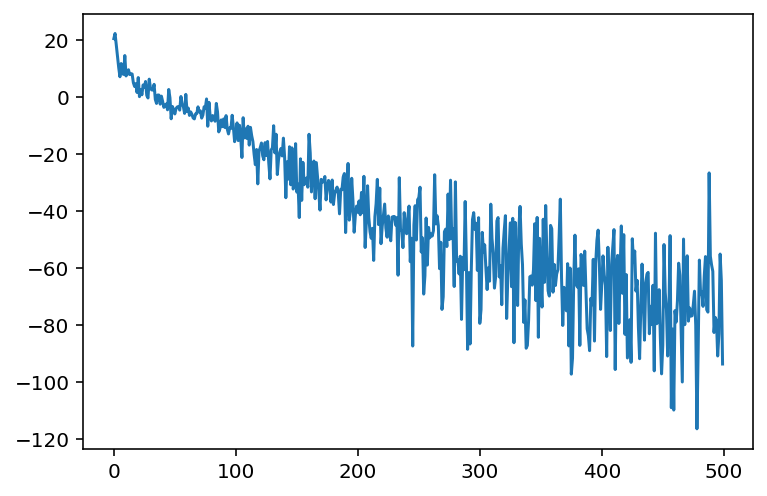

In [25]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots()
ax.plot(np.arange(len(losses_arr)), losses_arr)

`tensorflow`:

In [26]:
from src.l2hmc.configs import LossConfig
from src.l2hmc.loss.tensorflow.loss import LatticeLoss as tfLatticeLoss
from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf

optimizer_tf = tf.keras.optimizers.Adam(learning_rate=0.001)

xtf = tf.random.uniform(dynamics_tf.xshape, *(-np.pi, np.pi))
xtf = tf.reshape(xtf, (xtf.shape[0], -1))

loss_tf = tfLatticeLoss(lattice=tf_lattice,
                        loss_config=loss_config)
xtf, metrics_tf = train_step_tf((xtf, tf.constant(1.)),
                                 dynamics=dynamics_tf,
                                 optimizer=optimizer_tf,
                                 loss_fn=loss_tf)
losses[str(era)].append(metrics_tf['loss'])

In [27]:
from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf

losses = {}
history = {}
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=0.001)
xtf = tf.random.uniform(dynamics_tf.xshape, *(-np.pi, np.pi))
xtf = tf.reshape(xtf, (xtf.shape[0], -1))
dynamics_tf.compile(optimizer=optimizer_tf, loss=loss_tf)
for era in range(10):
    losses[str(era)] = []
    for epoch in range(50):
        xtf, metrics_tf = train_step_tf((xtf, tf.constant(1.)),
                                         dynamics=dynamics_tf,
                                         optimizer=optimizer_tf,
                                         loss_fn=loss_tf)
        losses[str(era)].append(metrics_tf['loss'])
        acc = tf.reduce_mean(metrics_tf['acc'])
        mstr = [f'epoch={epoch}', f'dt={metrics_tf["dt"]:.3g}', f'loss={metrics_tf["loss"]:.3g}', f'acc={acc:.3g}']
        print(', '.join(mstr))
        for key, val in metrics_tf.items():
            try:
                history[key].append(val)
            except KeyError:
                history[key] = [val]
    
    print(f'era: {era}, avg_loss: {np.mean(losses[str(era)]):.4g}')

epoch=0, dt=0.712, loss=16.5, acc=0.947

epoch=1, dt=0.444, loss=17.9, acc=0.939

epoch=2, dt=0.448, loss=10.9, acc=0.946

epoch=3, dt=0.443, loss=9.53, acc=0.926

epoch=4, dt=0.443, loss=8.59, acc=0.924

epoch=5, dt=0.447, loss=8.04, acc=0.941

epoch=6, dt=0.447, loss=9.37, acc=0.917

epoch=7, dt=0.445, loss=11.4, acc=0.925

epoch=8, dt=0.45, loss=7.91, acc=0.939

epoch=9, dt=0.448, loss=8.63, acc=0.917

epoch=10, dt=0.45, loss=3.64, acc=0.901

epoch=11, dt=0.457, loss=2.59, acc=0.934

epoch=12, dt=0.446, loss=4.18, acc=0.878

epoch=13, dt=0.444, loss=6.04, acc=0.893

epoch=14, dt=0.446, loss=4.97, acc=0.921

epoch=15, dt=0.443, loss=6.03, acc=0.894

epoch=16, dt=0.444, loss=1.27, acc=0.885

epoch=17, dt=0.451, loss=3.34, acc=0.799

epoch=18, dt=0.441, loss=4.63, acc=0.842

epoch=19, dt=0.442, loss=1.82, acc=0.763

epoch=20, dt=0.45, loss=7.36, acc=0.828

epoch=21, dt=0.453, loss=10.6, acc=0.84

epoch=22, dt=0.445, loss=2.8, acc=0.817

epoch=23, dt=0.445, loss=0.561, acc=0.782

epoch=24, dt=0.456, loss=-0.757, acc=0.778

epoch=25, dt=0.446, loss=-0.657, acc=0.812

epoch=26, dt=0.453, loss=2.42, acc=0.781

epoch=27, dt=0.444, loss=1.49, acc=0.724

epoch=28, dt=0.452, loss=-0.0308, acc=0.76

epoch=29, dt=0.453, loss=1.74, acc=0.656

epoch=30, dt=0.455, loss=4.27, acc=0.639

epoch=31, dt=0.448, loss=3.04, acc=0.602

epoch=32, dt=0.459, loss=8.1, acc=0.613

epoch=33, dt=0.476, loss=2.78, acc=0.732

epoch=34, dt=0.472, loss=7.44, acc=0.575

epoch=35, dt=0.478, loss=1.54, acc=0.651

epoch=36, dt=0.476, loss=0.644, acc=0.622

epoch=37, dt=0.486, loss=-1.98, acc=0.684

epoch=38, dt=0.492, loss=4.95, acc=0.647

epoch=39, dt=0.506, loss=4.21, acc=0.633

epoch=40, dt=0.503, loss=-0.0434, acc=0.616

epoch=41, dt=0.516, loss=0.187, acc=0.566

epoch=42, dt=0.522, loss=0.812, acc=0.656

epoch=43, dt=0.525, loss=2.61, acc=0.576

epoch=44, dt=0.52, loss=1.27, acc=0.517

epoch=45, dt=0.528, loss=5.62, acc=0.442

epoch=46, dt=0.55, loss=3.37, acc=0.473

epoch=47, dt=0.548, loss=3.49, acc=0.529

epoch=48, dt=0.567, loss=0.113, acc=0.553

epoch=49, dt=0.557, loss=5.5, acc=0.422

era: 0, avg_loss: 4.615

epoch=0, dt=0.558, loss=1.78, acc=0.474

epoch=1, dt=0.572, loss=0.485, acc=0.501

epoch=2, dt=0.582, loss=10.2, acc=0.428

epoch=3, dt=0.588, loss=6.21, acc=0.376

epoch=4, dt=0.594, loss=4.19, acc=0.469

epoch=5, dt=0.766, loss=7.98, acc=0.4

epoch=6, dt=0.603, loss=9.98, acc=0.356

epoch=7, dt=0.604, loss=9.03, acc=0.382

epoch=8, dt=0.602, loss=12.1, acc=0.387

epoch=9, dt=0.602, loss=1.85, acc=0.39

epoch=10, dt=0.631, loss=5.2, acc=0.39

epoch=11, dt=0.624, loss=6, acc=0.394

epoch=12, dt=0.637, loss=15.4, acc=0.314

epoch=13, dt=0.654, loss=6.19, acc=0.394

epoch=14, dt=0.657, loss=10.4, acc=0.336

epoch=15, dt=0.653, loss=14.9, acc=0.306

epoch=16, dt=0.651, loss=10.1, acc=0.437

epoch=17, dt=0.65, loss=7.96, acc=0.344

epoch=18, dt=0.665, loss=4.93, acc=0.398

epoch=19, dt=0.683, loss=8.06, acc=0.385

epoch=20, dt=0.69, loss=5.4, acc=0.338

epoch=21, dt=0.689, loss=15.6, acc=0.24

epoch=22, dt=0.715, loss=14.7, acc=0.3

epoch=23, dt=0.711, loss=17.9, acc=0.201

epoch=24, dt=0.717, loss=11.4, acc=0.252

epoch=25, dt=0.71, loss=22.5, acc=0.236

epoch=26, dt=0.713, loss=16.4, acc=0.255

epoch=27, dt=0.715, loss=14.6, acc=0.277

epoch=28, dt=0.713, loss=17.4, acc=0.246

epoch=29, dt=0.715, loss=15.1, acc=0.162

epoch=30, dt=0.753, loss=14.2, acc=0.27

epoch=31, dt=0.769, loss=15.9, acc=0.224

epoch=32, dt=0.743, loss=17.8, acc=0.207

epoch=33, dt=0.748, loss=13.8, acc=0.253

epoch=34, dt=0.751, loss=25.4, acc=0.199

epoch=35, dt=0.758, loss=5.45, acc=0.315

epoch=36, dt=0.75, loss=11, acc=0.22

epoch=37, dt=0.75, loss=22.3, acc=0.197

epoch=38, dt=0.813, loss=21.6, acc=0.167

epoch=39, dt=0.753, loss=16.6, acc=0.17

epoch=40, dt=0.751, loss=17.4, acc=0.233

epoch=41, dt=0.776, loss=19.6, acc=0.183

epoch=42, dt=0.866, loss=17.7, acc=0.183

epoch=43, dt=0.933, loss=18.2, acc=0.207

epoch=44, dt=0.902, loss=17.9, acc=0.209

epoch=45, dt=0.838, loss=23.1, acc=0.148

epoch=46, dt=0.891, loss=25.1, acc=0.18

epoch=47, dt=0.886, loss=25.3, acc=0.13

epoch=48, dt=0.87, loss=26.3, acc=0.0997

epoch=49, dt=0.911, loss=28.8, acc=0.208

era: 1, avg_loss: 13.75

epoch=0, dt=0.853, loss=24, acc=0.144

epoch=1, dt=1.03, loss=25.3, acc=0.17

epoch=2, dt=0.999, loss=36.6, acc=0.129

epoch=3, dt=0.921, loss=29.6, acc=0.0822

epoch=4, dt=1.11, loss=22.5, acc=0.128

epoch=5, dt=0.939, loss=29.8, acc=0.169

epoch=6, dt=0.95, loss=37.2, acc=0.107

epoch=7, dt=0.929, loss=32.6, acc=0.239

epoch=8, dt=0.936, loss=35.3, acc=0.167

epoch=9, dt=0.917, loss=45.3, acc=0.0754

epoch=10, dt=0.923, loss=27.1, acc=0.16

epoch=11, dt=0.922, loss=43.3, acc=0.136

epoch=12, dt=0.922, loss=32, acc=0.0933

epoch=13, dt=1.14, loss=37.6, acc=0.139

epoch=14, dt=0.916, loss=49.8, acc=0.0593

epoch=15, dt=0.927, loss=30.9, acc=0.148

epoch=16, dt=0.938, loss=34.1, acc=0.0934

epoch=17, dt=0.932, loss=42.1, acc=0.107

epoch=18, dt=0.93, loss=41.4, acc=0.127

epoch=19, dt=0.922, loss=36.6, acc=0.0884

epoch=20, dt=0.964, loss=34.3, acc=0.128

epoch=21, dt=0.985, loss=48.5, acc=0.0601

epoch=22, dt=0.983, loss=42.9, acc=0.0332

epoch=23, dt=0.993, loss=30.1, acc=0.102

epoch=24, dt=0.983, loss=38.9, acc=0.0575

epoch=25, dt=1.01, loss=41.3, acc=0.0889

epoch=26, dt=0.989, loss=53.6, acc=0.0529

epoch=27, dt=0.98, loss=47.2, acc=0.0843

epoch=28, dt=0.989, loss=54.3, acc=0.0596

epoch=29, dt=0.982, loss=49.3, acc=0.0611

epoch=30, dt=0.988, loss=43.6, acc=0.0974

epoch=31, dt=0.989, loss=53.1, acc=0.0446

epoch=32, dt=0.984, loss=41.4, acc=0.0743

epoch=33, dt=1.08, loss=44.9, acc=0.0774

epoch=34, dt=0.985, loss=43, acc=0.137

epoch=35, dt=0.991, loss=47.3, acc=0.0462

epoch=36, dt=1.02, loss=56.4, acc=0.0772

epoch=37, dt=1, loss=52.8, acc=0.0511

epoch=38, dt=1.04, loss=51.5, acc=0.0452

epoch=39, dt=0.982, loss=52.7, acc=0.0914

epoch=40, dt=0.983, loss=43.3, acc=0.0452

epoch=41, dt=0.986, loss=57.1, acc=0.0552

epoch=42, dt=0.989, loss=48.8, acc=0.0488

epoch=43, dt=0.993, loss=46.4, acc=0.05

epoch=44, dt=0.98, loss=55.5, acc=0.0093

epoch=45, dt=0.989, loss=44.4, acc=0.0493

epoch=46, dt=1.05, loss=62.1, acc=0.0289

epoch=47, dt=0.99, loss=60.7, acc=0.0379

epoch=48, dt=0.982, loss=62.4, acc=0.0653

epoch=49, dt=0.989, loss=66.9, acc=0.0373

era: 2, avg_loss: 43.36

epoch=0, dt=0.987, loss=47.3, acc=0.0492

epoch=1, dt=1.04, loss=60.7, acc=0.0567

epoch=2, dt=0.98, loss=61.7, acc=0.0367

epoch=3, dt=0.992, loss=55.1, acc=0.0702

epoch=4, dt=0.989, loss=57.4, acc=0.0467

epoch=5, dt=0.987, loss=56.8, acc=0.0634

epoch=6, dt=1.02, loss=57.3, acc=0.0195

epoch=7, dt=0.995, loss=58.5, acc=0.0339

epoch=8, dt=0.976, loss=64.7, acc=0.016

epoch=9, dt=0.974, loss=56.8, acc=0.0468

epoch=10, dt=0.987, loss=64.3, acc=0.0241

epoch=11, dt=0.984, loss=63.9, acc=0.0216

epoch=12, dt=0.994, loss=49.9, acc=0.0333

epoch=13, dt=0.987, loss=70.6, acc=0.0269

epoch=14, dt=0.982, loss=72.1, acc=0.0361

epoch=15, dt=0.995, loss=62.1, acc=0.0355

epoch=16, dt=0.989, loss=56.5, acc=0.0785

epoch=17, dt=0.99, loss=71.1, acc=0.00859

epoch=18, dt=1.01, loss=59.2, acc=0.0365

epoch=19, dt=0.983, loss=64.6, acc=0.0228

epoch=20, dt=1, loss=63, acc=0.0229

epoch=21, dt=1.21, loss=70.7, acc=0.00731

epoch=22, dt=0.982, loss=57.2, acc=0.0396

epoch=23, dt=0.997, loss=73.8, acc=0.0517

epoch=24, dt=0.993, loss=67.7, acc=0.0175

epoch=25, dt=0.986, loss=79.2, acc=0.0169

epoch=26, dt=1.08, loss=75.8, acc=0.019

epoch=27, dt=1.04, loss=74, acc=0.0223

epoch=28, dt=0.988, loss=66.8, acc=0.0282

epoch=29, dt=0.979, loss=64.4, acc=0.0444

epoch=30, dt=0.982, loss=67.5, acc=0.0513

epoch=31, dt=0.991, loss=73.9, acc=0.053

epoch=32, dt=1.02, loss=63.9, acc=0.0443

epoch=33, dt=1.02, loss=75.3, acc=0.0108

epoch=34, dt=1.24, loss=72, acc=0.0228

epoch=35, dt=0.993, loss=68.6, acc=0.0224

epoch=36, dt=1.01, loss=69.6, acc=0.0324

epoch=37, dt=0.985, loss=68, acc=0.0362

epoch=38, dt=0.991, loss=70.1, acc=0.0185

epoch=39, dt=0.995, loss=60.5, acc=0.0448

epoch=40, dt=0.987, loss=65.9, acc=0.0273

epoch=41, dt=0.978, loss=72.9, acc=0.0189

epoch=42, dt=0.984, loss=68.1, acc=0.00603

epoch=43, dt=0.987, loss=79.9, acc=0.0229

epoch=44, dt=1.05, loss=70.3, acc=0.0179

epoch=45, dt=1, loss=73.9, acc=0.0133

epoch=46, dt=0.994, loss=60.3, acc=0.0486

epoch=47, dt=0.991, loss=66.5, acc=0.0243

epoch=48, dt=0.986, loss=62, acc=0.0733

epoch=49, dt=0.991, loss=79.1, acc=0.0186

era: 3, avg_loss: 65.83

epoch=0, dt=0.977, loss=75.6, acc=0.017

epoch=1, dt=0.987, loss=79.3, acc=0.00095

epoch=2, dt=0.985, loss=80.3, acc=0.0198

epoch=3, dt=0.987, loss=73.4, acc=0.0358

epoch=4, dt=0.989, loss=67.4, acc=0.00172

epoch=5, dt=1, loss=68.7, acc=0.0406

epoch=6, dt=0.977, loss=73.9, acc=0.0245

epoch=7, dt=1.25, loss=79, acc=0.0171

epoch=8, dt=0.988, loss=74.9, acc=0.0177

epoch=9, dt=1.06, loss=79.6, acc=0.00878

epoch=10, dt=1.06, loss=77.4, acc=0.00384

epoch=11, dt=0.981, loss=78.8, acc=0.002

epoch=12, dt=1.06, loss=61.2, acc=0.0333

epoch=13, dt=0.989, loss=73, acc=0.00143

epoch=14, dt=0.978, loss=82.6, acc=0.0104

epoch=15, dt=1, loss=63.2, acc=0.0369

epoch=16, dt=0.987, loss=69.6, acc=0.0204

epoch=17, dt=0.998, loss=71.1, acc=0.0335

epoch=18, dt=1.08, loss=82.6, acc=0.00187

epoch=19, dt=1.01, loss=73.4, acc=0.0126

epoch=20, dt=0.998, loss=74.6, acc=0.0145

epoch=21, dt=0.978, loss=89.5, acc=0.000685

epoch=22, dt=1, loss=72.7, acc=0.00549

epoch=23, dt=0.999, loss=77, acc=0.0178

epoch=24, dt=0.983, loss=67.6, acc=0.0295

epoch=25, dt=1.07, loss=85.8, acc=0.00178

epoch=26, dt=0.988, loss=83.2, acc=0.00211

epoch=27, dt=0.988, loss=85.5, acc=0.000392

epoch=28, dt=1.01, loss=88, acc=0.00327

epoch=29, dt=1.21, loss=82.8, acc=0.00261

epoch=30, dt=1.8, loss=85.6, acc=0.00284

epoch=31, dt=1.74, loss=75.5, acc=0.0317

epoch=32, dt=1.06, loss=76.6, acc=0.00932

epoch=33, dt=1.08, loss=78.7, acc=0.0215

epoch=34, dt=1.04, loss=83.6, acc=0.00724

epoch=35, dt=1.1, loss=83.4, acc=0.00202

epoch=36, dt=1.07, loss=77.2, acc=0.0272

epoch=37, dt=1.06, loss=81.8, acc=0.00771

epoch=38, dt=1.07, loss=78.3, acc=0.0112

epoch=39, dt=1.08, loss=81.5, acc=0.00563

epoch=40, dt=1.07, loss=80.4, acc=0.0179

epoch=41, dt=1.07, loss=83, acc=0.0161

epoch=42, dt=1.09, loss=79.7, acc=0.0192

epoch=43, dt=1.08, loss=84.9, acc=0.0192

epoch=44, dt=1.1, loss=77.3, acc=0.00301

epoch=45, dt=1.07, loss=88.1, acc=0.000214

epoch=46, dt=1.08, loss=82.8, acc=0.0225

epoch=47, dt=1.06, loss=81.1, acc=0.0208

epoch=48, dt=1.05, loss=83.6, acc=0.0327

epoch=49, dt=1.08, loss=81.3, acc=0.00232

era: 4, avg_loss: 78.32

epoch=0, dt=1.05, loss=81.9, acc=0.0065

epoch=1, dt=1.06, loss=77.2, acc=0.0198

epoch=2, dt=1.14, loss=84, acc=0.00355

epoch=3, dt=1.06, loss=87.5, acc=0.000382

epoch=4, dt=1.06, loss=81.4, acc=0.047

epoch=5, dt=1.07, loss=88, acc=0.00463

epoch=6, dt=1.07, loss=86.2, acc=0.0045

epoch=7, dt=1.07, loss=83, acc=0.0123

epoch=8, dt=1.06, loss=78.2, acc=0.00292

epoch=9, dt=1.08, loss=78.1, acc=0.0168

epoch=10, dt=1.07, loss=85.2, acc=0.000428

epoch=11, dt=1.07, loss=82.8, acc=0.0191

epoch=12, dt=1.07, loss=85.6, acc=0.0252

epoch=13, dt=1.06, loss=86.6, acc=0.00106

epoch=14, dt=1.09, loss=83.3, acc=0.00218

epoch=15, dt=1.07, loss=85.7, acc=0.000865

epoch=16, dt=1.15, loss=85.7, acc=0.00812

epoch=17, dt=1.05, loss=78.9, acc=0.0185

epoch=18, dt=1.07, loss=88.5, acc=0.0157

epoch=19, dt=1.07, loss=82.4, acc=0.0215

epoch=20, dt=1.1, loss=83.5, acc=0.00522

epoch=21, dt=1.07, loss=79.5, acc=0.0182

epoch=22, dt=1.07, loss=92.3, acc=0.00048

epoch=23, dt=1.05, loss=81.2, acc=0.0161

epoch=24, dt=1.04, loss=91, acc=0.000527

epoch=25, dt=1.05, loss=83.9, acc=0.0013

epoch=26, dt=1.05, loss=89.9, acc=0.00832

epoch=27, dt=1.06, loss=78.7, acc=0.00901

epoch=28, dt=1.05, loss=84.8, acc=0.0174

epoch=29, dt=1.08, loss=86.4, acc=0.00677

epoch=30, dt=1.06, loss=89, acc=0.019

epoch=31, dt=1.07, loss=79.5, acc=0.0422

epoch=32, dt=1.06, loss=87.9, acc=0.011

epoch=33, dt=1.04, loss=84.7, acc=0.00172

epoch=34, dt=1.05, loss=86.6, acc=0.0112

epoch=35, dt=1.07, loss=82.4, acc=0.0242

epoch=36, dt=1.08, loss=87.5, acc=0.000667

epoch=37, dt=1.31, loss=84.5, acc=0.00411

epoch=38, dt=1.08, loss=90, acc=0.000113

epoch=39, dt=1.13, loss=83.1, acc=0.00641

epoch=40, dt=1.05, loss=88.6, acc=0.00524

epoch=41, dt=1.05, loss=89.3, acc=0.00151

epoch=42, dt=1.05, loss=93, acc=7.31e-05

epoch=43, dt=1.04, loss=89.4, acc=0.00307

epoch=44, dt=1.07, loss=82.9, acc=0.0206

epoch=45, dt=1.05, loss=92.7, acc=0.000315

epoch=46, dt=1.07, loss=91.9, acc=0.00142

epoch=47, dt=1.03, loss=84.5, acc=0.00572

epoch=48, dt=0.982, loss=84.4, acc=0.00834

epoch=49, dt=1.22, loss=87.6, acc=0.0142

era: 5, avg_loss: 85.23

epoch=0, dt=1.21, loss=87.6, acc=0.00101

epoch=1, dt=1.11, loss=92.8, acc=0.00073

epoch=2, dt=0.993, loss=89, acc=0.000452

epoch=3, dt=0.986, loss=78.4, acc=0.0162

epoch=4, dt=0.989, loss=90.2, acc=0.0169

epoch=5, dt=0.982, loss=85.5, acc=0.00734

epoch=6, dt=0.99, loss=87.7, acc=0.00189

epoch=7, dt=0.985, loss=80.2, acc=0.0194

epoch=8, dt=1.03, loss=87.4, acc=0.00216

epoch=9, dt=1.01, loss=92.7, acc=4.82e-05

epoch=10, dt=0.987, loss=88, acc=0.000544

epoch=11, dt=0.987, loss=87.8, acc=0.0158

epoch=12, dt=0.984, loss=86.3, acc=0.000886

epoch=13, dt=1.05, loss=90.8, acc=0.0001

epoch=14, dt=0.99, loss=86.9, acc=0.000705

epoch=15, dt=0.99, loss=89.1, acc=0.000209

epoch=16, dt=0.985, loss=88.4, acc=0.00323

epoch=17, dt=1.21, loss=90.2, acc=0.000711

epoch=18, dt=1, loss=75.1, acc=0.0139

epoch=19, dt=0.996, loss=85.9, acc=0.0159

epoch=20, dt=0.986, loss=85.8, acc=0.000427

epoch=21, dt=1.07, loss=90.6, acc=0.00151

epoch=22, dt=1.03, loss=85.8, acc=0.00333

epoch=23, dt=0.979, loss=83.9, acc=0.0249

epoch=24, dt=0.993, loss=87.6, acc=0.00123

epoch=25, dt=1.01, loss=88.6, acc=0.000483

epoch=26, dt=0.991, loss=88.2, acc=0.000531

epoch=27, dt=1.02, loss=88.9, acc=0.00098

epoch=28, dt=1.02, loss=87, acc=0.0106

epoch=29, dt=0.985, loss=79, acc=0.0161

epoch=30, dt=0.995, loss=91.9, acc=0.000293

epoch=31, dt=0.992, loss=86.9, acc=0.0101

epoch=32, dt=0.986, loss=91.4, acc=0.000377

epoch=33, dt=1.01, loss=92.4, acc=0.00173

epoch=34, dt=1, loss=91.5, acc=0.000201

epoch=35, dt=0.992, loss=91.7, acc=0.000729

epoch=36, dt=0.972, loss=90.9, acc=0.000543

epoch=37, dt=0.926, loss=88.3, acc=0.0019

epoch=38, dt=0.935, loss=91.8, acc=0.00171

epoch=39, dt=0.93, loss=90.9, acc=0.000133

epoch=40, dt=0.921, loss=95.2, acc=0.00142

epoch=41, dt=0.925, loss=83.5, acc=0.0173

epoch=42, dt=0.935, loss=90.6, acc=0.00187

epoch=43, dt=0.925, loss=91, acc=0.000937

epoch=44, dt=0.916, loss=88.8, acc=0.000356

epoch=45, dt=1.14, loss=83.6, acc=0.00107

epoch=46, dt=0.922, loss=87.8, acc=0.0161

epoch=47, dt=0.93, loss=92.4, acc=0.000126

epoch=48, dt=0.976, loss=88.5, acc=0.00926

epoch=49, dt=0.922, loss=91.7, acc=0.000371

era: 6, avg_loss: 88.13

epoch=0, dt=0.93, loss=86.7, acc=0.000308

epoch=1, dt=0.918, loss=92.1, acc=0.00326

epoch=2, dt=0.941, loss=91.1, acc=0.000216

epoch=3, dt=0.924, loss=90.2, acc=0.00189

epoch=4, dt=0.88, loss=91.5, acc=0.00913

epoch=5, dt=0.868, loss=90.8, acc=0.000738

epoch=6, dt=0.876, loss=91.3, acc=0.000443

epoch=7, dt=0.876, loss=91.4, acc=0.00015

epoch=8, dt=0.881, loss=86.1, acc=0.0158

epoch=9, dt=0.88, loss=89.9, acc=0.000246

epoch=10, dt=0.874, loss=88.7, acc=0.00153

epoch=11, dt=0.889, loss=92.8, acc=3.77e-05

epoch=12, dt=0.872, loss=89.3, acc=0.0001

epoch=13, dt=0.9, loss=93.8, acc=0.000773

epoch=14, dt=0.883, loss=91.7, acc=0.000639

epoch=15, dt=0.873, loss=95.9, acc=0.000847

epoch=16, dt=0.874, loss=94.4, acc=0.00024

epoch=17, dt=0.868, loss=92.4, acc=0.00385

epoch=18, dt=0.885, loss=82.1, acc=0.00105

epoch=19, dt=0.867, loss=91.7, acc=0.00634

epoch=20, dt=0.901, loss=92.8, acc=0.000123

epoch=21, dt=0.865, loss=90, acc=0.00141

epoch=22, dt=0.874, loss=93.8, acc=0.00349

epoch=23, dt=0.865, loss=87.2, acc=0.0119

epoch=24, dt=0.862, loss=93.3, acc=0.000567

epoch=25, dt=0.824, loss=89.5, acc=0.0157

epoch=26, dt=0.825, loss=88.4, acc=0.000976

epoch=27, dt=0.836, loss=92.1, acc=0.00288

epoch=28, dt=0.834, loss=87.2, acc=0.0221

epoch=29, dt=0.823, loss=86.4, acc=0.00182

epoch=30, dt=0.831, loss=87.9, acc=0.0168

epoch=31, dt=0.827, loss=92.5, acc=8.91e-05

epoch=32, dt=0.822, loss=92.3, acc=0.000164

epoch=33, dt=0.828, loss=91.5, acc=0.00103

epoch=34, dt=0.828, loss=90.4, acc=0.00809

epoch=35, dt=0.88, loss=86.4, acc=0.0165

epoch=36, dt=0.82, loss=87.2, acc=0.00235

epoch=37, dt=0.831, loss=94.5, acc=0.000502

epoch=38, dt=0.905, loss=89.7, acc=0.0028

epoch=39, dt=0.828, loss=91.8, acc=0.00691

epoch=40, dt=0.82, loss=90.8, acc=0.00265

epoch=41, dt=0.834, loss=91.7, acc=0.0163

epoch=42, dt=0.83, loss=89.5, acc=0.00106

epoch=43, dt=0.827, loss=86.7, acc=0.0184

epoch=44, dt=0.84, loss=84.2, acc=0.00172

epoch=45, dt=0.833, loss=91.8, acc=5.99e-05

epoch=46, dt=0.802, loss=86.7, acc=0.00594

epoch=47, dt=0.781, loss=96.8, acc=1.07e-05

epoch=48, dt=0.777, loss=76.6, acc=0.0158

epoch=49, dt=0.786, loss=84.4, acc=0.0277

era: 7, avg_loss: 89.96

epoch=0, dt=0.783, loss=91.3, acc=4.13e-05

epoch=1, dt=0.792, loss=91.3, acc=0.000116

epoch=2, dt=0.779, loss=88.4, acc=0.00245

epoch=3, dt=0.981, loss=91, acc=0.00752

epoch=4, dt=0.78, loss=90.5, acc=0.00411

epoch=5, dt=0.794, loss=88.6, acc=0.00403

epoch=6, dt=0.797, loss=82.9, acc=0.0176

epoch=7, dt=0.785, loss=94.6, acc=0.000652

epoch=8, dt=0.784, loss=88.3, acc=0.0148

epoch=9, dt=0.788, loss=80.4, acc=0.0224

epoch=10, dt=0.781, loss=89.2, acc=0.00107

epoch=11, dt=0.786, loss=89.2, acc=0.000485

epoch=12, dt=0.788, loss=90.6, acc=0.00136

epoch=13, dt=0.79, loss=92.6, acc=0.0157

epoch=14, dt=0.792, loss=90.5, acc=0.000114

epoch=15, dt=0.833, loss=94.7, acc=0.000601

epoch=16, dt=1.22, loss=92, acc=0.0011

epoch=17, dt=0.843, loss=92.3, acc=0.000325

epoch=18, dt=0.825, loss=96, acc=0.000685

epoch=19, dt=0.792, loss=88.5, acc=0.0139

epoch=20, dt=0.783, loss=86.3, acc=0.000642

epoch=21, dt=0.79, loss=94, acc=0.000112

epoch=22, dt=0.79, loss=92.6, acc=0.000256

epoch=23, dt=0.789, loss=97.9, acc=1.11e-05

epoch=24, dt=0.783, loss=92.3, acc=0.00193

epoch=25, dt=1.17, loss=96.4, acc=0.000225

epoch=26, dt=0.896, loss=89.2, acc=0.00116

epoch=27, dt=0.823, loss=90, acc=0.00195

epoch=28, dt=1.19, loss=95.9, acc=1.63e-05

epoch=29, dt=0.969, loss=97, acc=0.000722

epoch=30, dt=0.829, loss=96.1, acc=4.56e-05

epoch=31, dt=0.804, loss=98.5, acc=5.4e-06

epoch=32, dt=0.839, loss=90.6, acc=0.0157

epoch=33, dt=0.796, loss=93.2, acc=0.000127

epoch=34, dt=0.802, loss=92.6, acc=0.000904

epoch=35, dt=0.819, loss=96.3, acc=4.86e-05

epoch=36, dt=0.847, loss=94.8, acc=4.67e-05

epoch=37, dt=0.807, loss=93.8, acc=3.62e-05

epoch=38, dt=0.815, loss=92.8, acc=0.00273

epoch=39, dt=0.788, loss=91.4, acc=0.00265

epoch=40, dt=0.887, loss=94.9, acc=0.000144

epoch=41, dt=0.889, loss=95.9, acc=0.0026

epoch=42, dt=0.883, loss=94.6, acc=0.000684

epoch=43, dt=0.864, loss=91.4, acc=7.72e-05

epoch=44, dt=0.949, loss=92, acc=0.00141

epoch=45, dt=0.836, loss=92.1, acc=0.000383

epoch=46, dt=0.831, loss=93.1, acc=0.000446

epoch=47, dt=0.916, loss=91.5, acc=0.0165

epoch=48, dt=0.831, loss=95.5, acc=0.00463

epoch=49, dt=0.854, loss=97.6, acc=3.56e-05

era: 8, avg_loss: 92.26

epoch=0, dt=0.938, loss=92.1, acc=0.00047

epoch=1, dt=0.842, loss=96.5, acc=3.66e-05

epoch=2, dt=0.836, loss=91.2, acc=0.00347

epoch=3, dt=0.878, loss=93, acc=0.0078

epoch=4, dt=0.849, loss=95.3, acc=4.64e-05

epoch=5, dt=1.04, loss=97.3, acc=0.000284

epoch=6, dt=0.881, loss=92.7, acc=0.0163

epoch=7, dt=0.897, loss=93.8, acc=0.000215

epoch=8, dt=0.944, loss=94.8, acc=6.43e-05

epoch=9, dt=0.927, loss=93.4, acc=0.00215

epoch=10, dt=0.949, loss=97.9, acc=5.04e-06

epoch=11, dt=1.14, loss=89.9, acc=0.0029

epoch=12, dt=1.07, loss=94.8, acc=8.02e-05

epoch=13, dt=1.26, loss=96.2, acc=8.84e-06

epoch=14, dt=1.15, loss=94.9, acc=0.00124

epoch=15, dt=1, loss=98, acc=3.72e-05

epoch=16, dt=0.989, loss=93.7, acc=0.000658

epoch=17, dt=0.969, loss=98.4, acc=4.12e-06

epoch=18, dt=0.936, loss=95.7, acc=0.000287

epoch=19, dt=0.987, loss=90.2, acc=0.000143

epoch=20, dt=0.939, loss=98.2, acc=0.000293

epoch=21, dt=0.966, loss=92.9, acc=8.4e-05

epoch=22, dt=1.01, loss=93.2, acc=5.27e-05

epoch=23, dt=1.03, loss=91.3, acc=0.0055

epoch=24, dt=1.04, loss=91.7, acc=0.00627

epoch=25, dt=1.03, loss=93.7, acc=0.00292

epoch=26, dt=1.02, loss=94.1, acc=0.000952

epoch=27, dt=1.02, loss=96.8, acc=3.1e-05

epoch=28, dt=0.996, loss=95.4, acc=5.3e-05

epoch=29, dt=1.08, loss=91.5, acc=0.0191

epoch=30, dt=1.1, loss=91.7, acc=0.00903

epoch=31, dt=1.04, loss=93.7, acc=0.0157

epoch=32, dt=1.06, loss=92.4, acc=0.000376

epoch=33, dt=1.1, loss=94.6, acc=0.0156

epoch=34, dt=1.11, loss=95.9, acc=0.000256

epoch=35, dt=1.82, loss=98.2, acc=4.13e-06

epoch=36, dt=1.26, loss=96.5, acc=1.55e-05

epoch=37, dt=1.27, loss=90.8, acc=0.0157

epoch=38, dt=1.62, loss=92.3, acc=0.00571

epoch=39, dt=1.41, loss=96.3, acc=0.000355

epoch=40, dt=1.61, loss=98.1, acc=0.000105

epoch=41, dt=1.44, loss=95.9, acc=1.64e-05

epoch=42, dt=1.4, loss=93.3, acc=0.00012

epoch=43, dt=1.28, loss=96.4, acc=3.86e-05

epoch=44, dt=1.5, loss=98.2, acc=3.72e-05

epoch=45, dt=1.64, loss=95.4, acc=0.000283

epoch=46, dt=1.63, loss=95, acc=0.00013

epoch=47, dt=1.61, loss=95.8, acc=0.000333

epoch=48, dt=1.61, loss=98, acc=0.000234

epoch=49, dt=1.41, loss=98, acc=1.68e-06

era: 9, avg_loss: 94.7

In [28]:
metrics_tf['loss']

0.3984117

In [33]:
metrics_tf['loss']

1.3026223

# 